In [1]:
#real 이미지 생성 함수
import torch
import random
def generate_real():
    real_data = torch.FloatTensor(
        [random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2),
         random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2)]
    )
    return real_data

In [2]:
#random 이미지 생성 함수
def generate_random(size):
    random_data = torch.rand(size)
    return random_data

In [3]:
#판별모형
import torch.nn as nn
import pandas as pd
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )

        self.loss_function = nn.MSELoss()
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        outputs = self.forward(inputs)

        loss = self.loss_function(outputs, targets)
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())

        if self.counter % 10000 == 0:
            print('counter = ', self.counter)
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

In [9]:
D = Discriminator()
for i in range(10000):
    # real image
    D.train(generate_real(), torch.FloatTensor([1.0]))
    # fake image
    D.train(generate_random(4), torch.FloatTensor([0.0]))

counter =  10000
counter =  20000


In [10]:
print(D.forward(generate_real()).item())
print(D.forward(generate_random(4)).item())

0.839434027671814
0.17935404181480408


In [11]:
#생성모형
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(1, 3),
            nn.Sigmoid(),
            nn.Linear(3, 4),
            nn.Sigmoid()
        )

        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)
        
        d_output = D.forward(g_output)

        loss = D.loss_function(d_output, targets)
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

In [12]:
G = Generator()
G.forward(torch.FloatTensor([0.5]))

tensor([0.3603, 0.6437, 0.5373, 0.6135], grad_fn=<SigmoidBackward0>)

In [14]:
D = Discriminator()
G = Generator()
image_list = []
for i in range(10000):
    # 판별모형 학습(true)
    D.train(generate_real(), torch.FloatTensor([1.0]))

    # 판별모형 학습(false)
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))
    
    # 생성모형 학습
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))

    if i % 1000 == 0:
        image_list.append(G.forward(torch.FloatTensor([0.5])).detach().numpy())

counter =  10000
counter =  20000


In [15]:
G.forward(torch.FloatTensor([0.5]))

tensor([0.9239, 0.0407, 0.9475, 0.0745], grad_fn=<SigmoidBackward0>)

In [16]:
#생성된 패턴
image_list

[array([0.5440139, 0.516285 , 0.3800554, 0.2590642], dtype=float32),
 array([0.5458138 , 0.48802075, 0.39894566, 0.2556341 ], dtype=float32),
 array([0.56535316, 0.42722133, 0.446502  , 0.24957307], dtype=float32),
 array([0.6113676 , 0.32512176, 0.5452371 , 0.23494   ], dtype=float32),
 array([0.6811431 , 0.21435031, 0.68396795, 0.20808376], dtype=float32),
 array([0.7554152 , 0.13788031, 0.79781693, 0.17420949], dtype=float32),
 array([0.81635934, 0.09478079, 0.86478347, 0.14236903], dtype=float32),
 array([0.8599855 , 0.07050564, 0.90211385, 0.11694984], dtype=float32),
 array([0.88959634, 0.05601792, 0.9241204 , 0.09811894], dtype=float32),
 array([0.9097913 , 0.04681724, 0.93808556, 0.08443429], dtype=float32)]

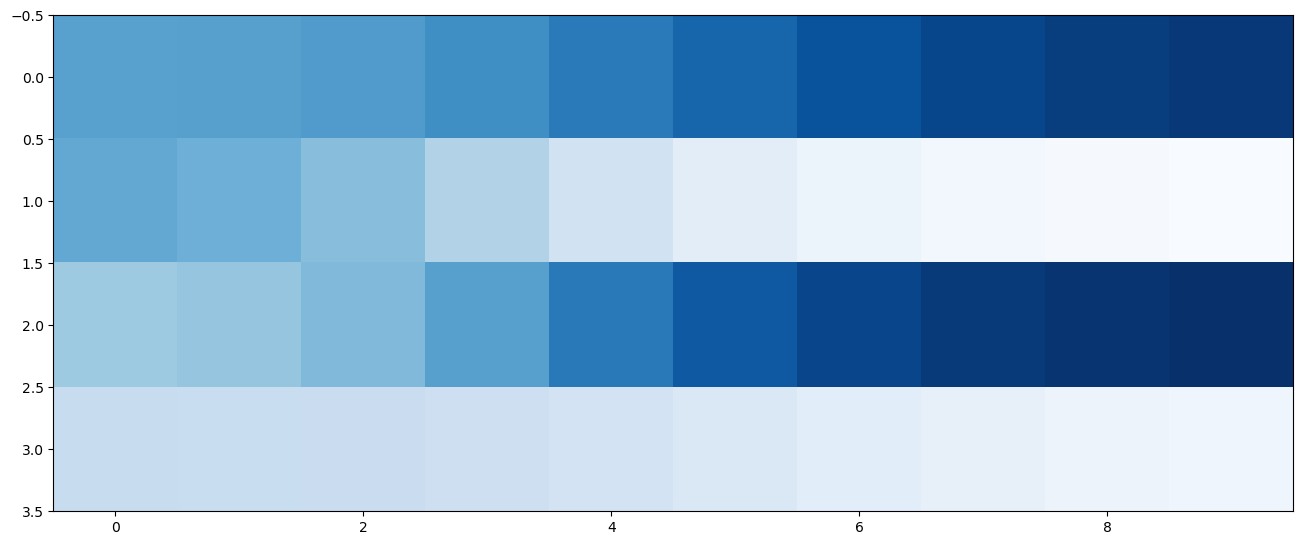

In [17]:
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
plt.figure(figsize = (16,8))
plt.imshow(np.array(image_list).T, interpolation='none', cmap='Blues')
plt.show()